# Lab 2 : Decision Tree

## Preparing the dataset

Import necessary libraries and routines.

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt, image as mpimg
import pydotplus

Download the dataset.

In [2]:
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


Load dataset from drive to memory in `pandas.DataFrame`.

In [3]:
from ucimlrepo import fetch_ucirepo
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

feature = breast_cancer_wisconsin_diagnostic.data.features
label = breast_cancer_wisconsin_diagnostic.data.targets

Create 4 copies of the original dataset. For each one, split it into two parts: train and test. The propotion of splitting for each copy is: 60/40, 40/60, 80/20, 90/10.

In [4]:
feature_train, label_train = dict(), dict()
feature_test, label_test = dict(), dict()

train_test_propotions = ['60/40', '40/60', '80/20', '90/10']

for propotion in train_test_propotions:
    test_size = 1 - int(propotion.split('/')[0]) / 100
    X_train, X_test, y_train, y_test = train_test_split(
        feature, label, 
        test_size=test_size,
        random_state=42,
        stratify=label)
    feature_train[propotion] = X_train
    label_train[propotion] = y_train
    feature_test[propotion] = X_test
    label_test[propotion] = y_test

## Building the tree classifier

Train 4 models and save them along with their accuracies.

In [5]:
models = dict()

for propotion in train_test_propotions:
    model = DecisionTreeClassifier()
    model.fit(feature_train[propotion], label_train[propotion])
    models[propotion] = model

`export_model_image` function exports visualizing image of the decision tree.

In [6]:
def export_model_image(model, filename):
    dot_data = export_graphviz(model, 
                            out_file=None, 
                            feature_names=[feature_name for feature_name in feature], 
                            class_names=['benign', 'malignant'],
                            filled=True, 
                            rounded=True,
                            special_characters=True)

    filename += '.png'
    pydotplus.graph_from_dot_data(dot_data).write_png(filename)
    plt.figure(figsize=(12,12))
    img = mpimg.imread(filename)
    plt.imshow(img)
    plt.show()

Export visualizations of all models. Images are saved in `images/decision_tree_classifier`.

Visualization of Decision Tree Classifier 60/40:


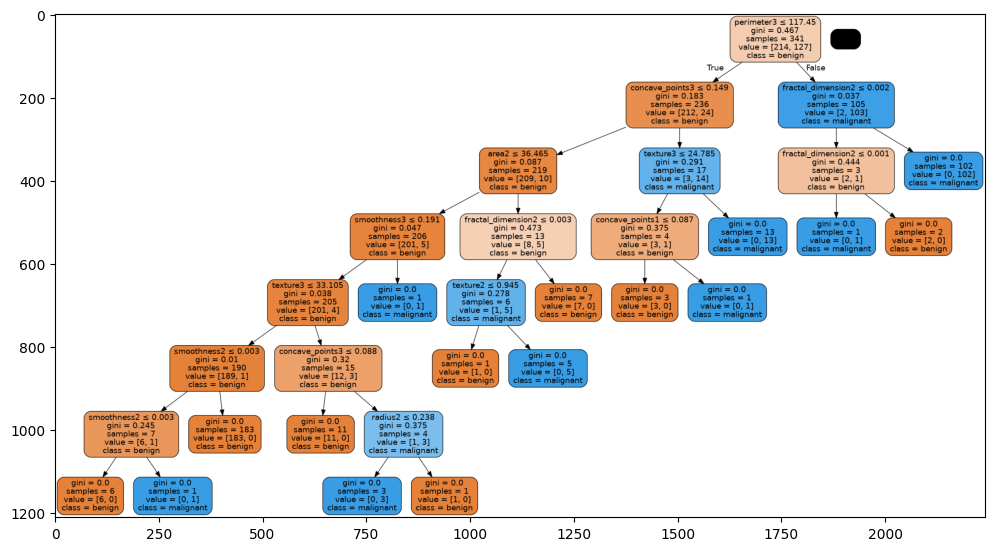

Visualization of Decision Tree Classifier 40/60:


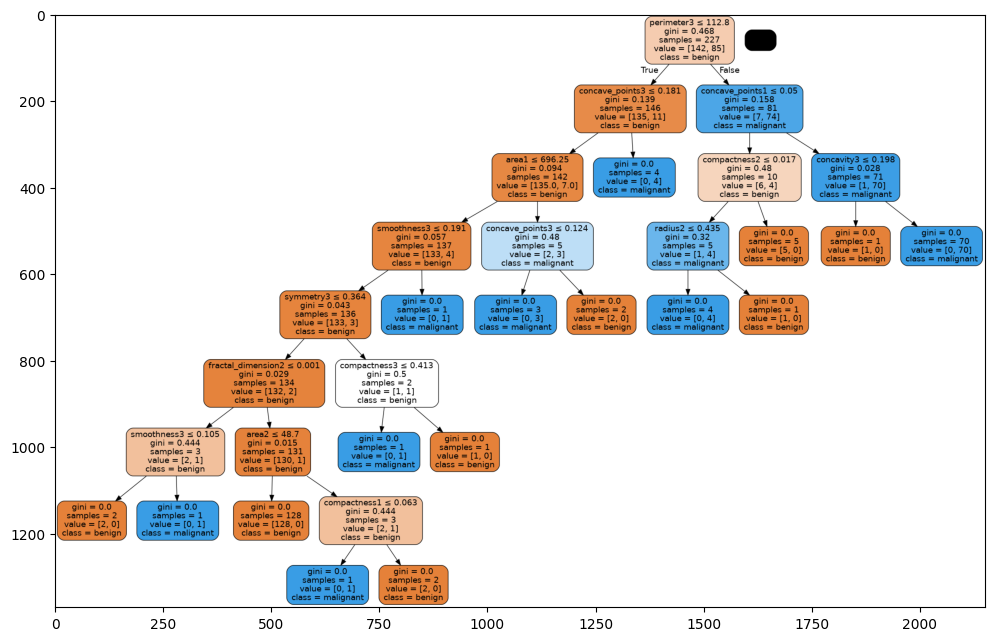

Visualization of Decision Tree Classifier 80/20:


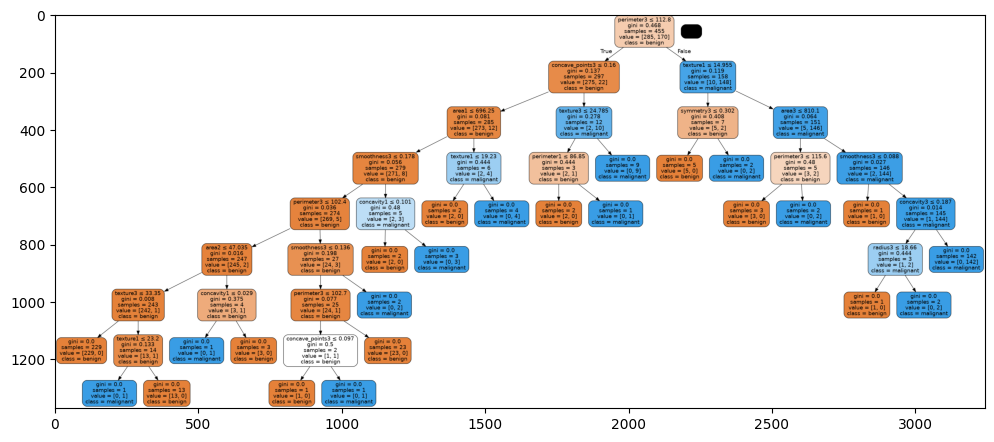

Visualization of Decision Tree Classifier 90/10:


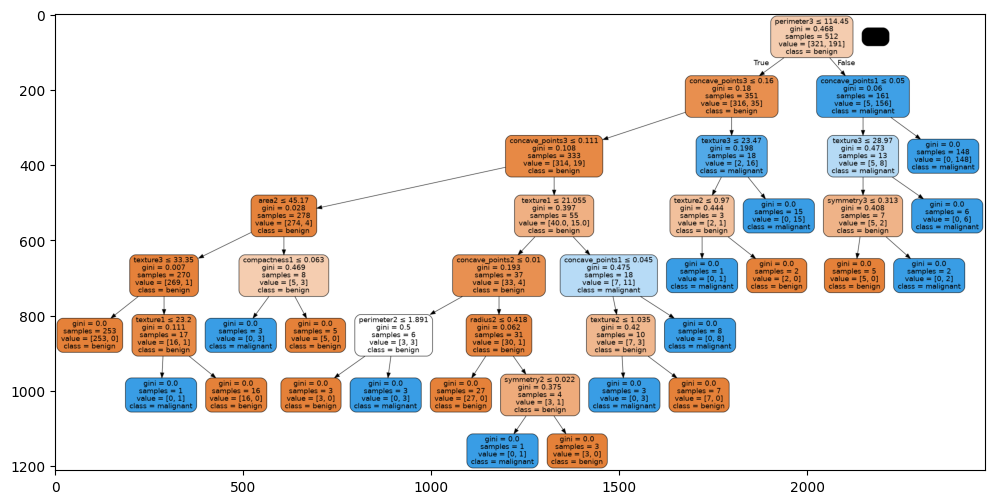

In [7]:
if os.path.exists('images') == False:
    os.mkdir('images')

if os.path.exists('images/decision_tree_classifier') == False:
    os.mkdir('images/decision_tree_classifier')

for propotion, model in models.items():
    print(f'Visualization of Decision Tree Classifier {propotion}:')
    propotion = propotion.replace('/', '-')
    export_model_image(model, f'images/decision_tree_classifier/model_on_{propotion}')

## Evaluating the decision tree classifiers

### Explanation

#### `confusion_matrix`

In the confusion matrix $C$, the row represents the actual Benign or Malignant classes, while the column represents the prediction of the model.
- $C_{0,0}$: Both the truth and the prediction are Benign
- $C_{0,1}$: The truth is Benign, but the prediction is Malignant
- $C_{1,0}$: The truth is Malignant, but the prediction is Benign
- $C_{1,1}$: Both the truth and the prediction are Malignant

#### `classification_report`

The Precision, Recall and F1 Score can be calculated based on which type of class is chosen to be Positive. For example: if Malignant as Positive, Benign as Negative. *For more detail, please refer to the report document.*

1. precision: **What percentage of all the Positive predictions made by the model were accurate?** The formula: $$Precision=\frac{True \ Positives}{True \ Positives + False \ Positives}$$

2. recall: **What percentage of all the actual Positives were accurately predicted by the model?** The formula: $$Recall=\frac{True \ Positive}{True \ Positive + False \ Negative}$$

3. F1 Score: **The harmonic mean of Precision and Recall.** If any of them becomes extremely low, F1 Score will also go down. Thus, F1 Score can help you find a good balance between Precision and Recall. The formula: $$F1 \ Score=\frac{2 \times Precision \times Recall}{Precision + Recall}$$

4. Support: **How many samples are in each class.** It uses the ground truth labels, which represent the actual class of each sample.

### Plotting

`plot_evaluation(model_name, cls_report, conf_matrix)` function receives model's name, its classification report and confusion matrix to plot evaluation of the model.

In [8]:
def plot_evaluation(model_name, cls_report, conf_matrix):
    print(f'Model: {model_name}')
    print(f'Classification Report:\n{cls_report}')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['benign', 'malignant'])
    disp.plot()

Create classification report and confusion matrix for each model.

In [9]:
evaluation_metrics = dict()

for model_name, model in models.items():
    cls_report = classification_report(label_test[model_name], model.predict(feature_test[model_name])) 
    conf_matrix = confusion_matrix(label_test[model_name], model.predict(feature_test[model_name]))
    evaluation_metrics[model_name] = (cls_report, conf_matrix)

Plotting evaluations of all 4 models

Model: 60/40
Classification Report:
              precision    recall  f1-score   support

           B       0.93      0.97      0.95       143
           M       0.94      0.88      0.91        85

    accuracy                           0.93       228
   macro avg       0.93      0.92      0.93       228
weighted avg       0.93      0.93      0.93       228



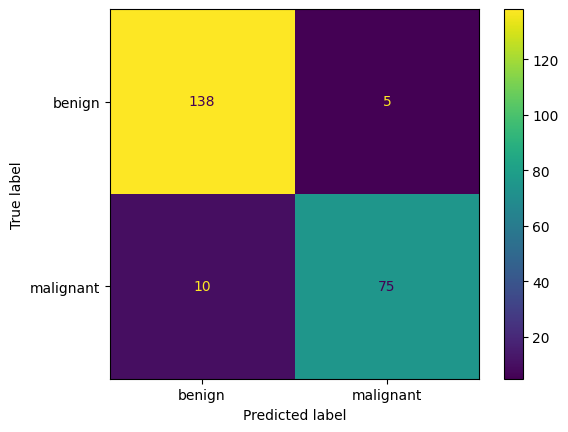

In [10]:
plot_evaluation('60/40', *evaluation_metrics['60/40'])

Model: 40/60
Classification Report:
              precision    recall  f1-score   support

           B       0.91      0.94      0.93       215
           M       0.89      0.85      0.87       127

    accuracy                           0.91       342
   macro avg       0.90      0.89      0.90       342
weighted avg       0.91      0.91      0.91       342



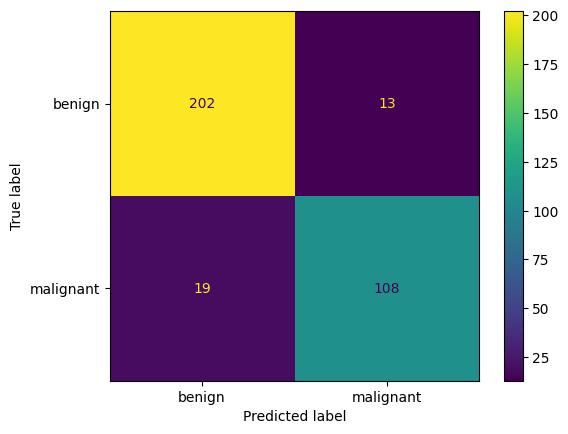

In [11]:
plot_evaluation('40/60', *evaluation_metrics['40/60'])

Model: 80/20
Classification Report:
              precision    recall  f1-score   support

           B       0.93      0.93      0.93        72
           M       0.88      0.88      0.88        42

    accuracy                           0.91       114
   macro avg       0.91      0.91      0.91       114
weighted avg       0.91      0.91      0.91       114



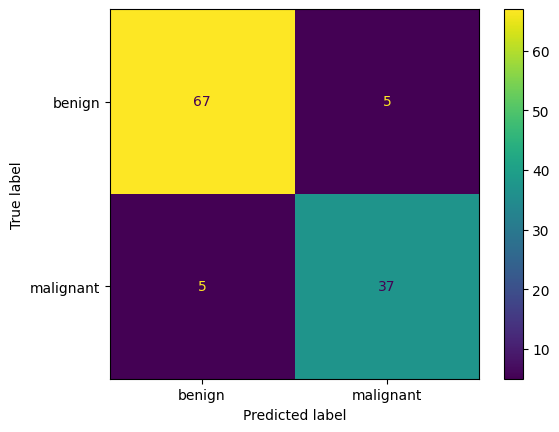

In [12]:
plot_evaluation('80/20', *evaluation_metrics['80/20'])

Model: 90/10
Classification Report:
              precision    recall  f1-score   support

           B       0.92      0.94      0.93        36
           M       0.90      0.86      0.88        21

    accuracy                           0.91        57
   macro avg       0.91      0.90      0.90        57
weighted avg       0.91      0.91      0.91        57



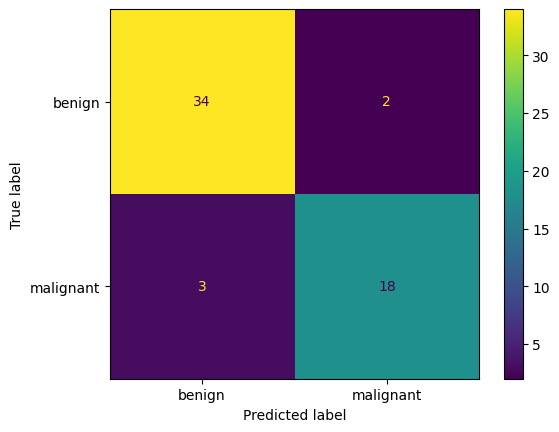

In [13]:
plot_evaluation('90/10', *evaluation_metrics['90/10'])

*For comments, please refer to the report document.*

## The depth and accuracy of a decision tree

This task works on the dataset of 80/20 train-test propotion.

Prepare the dataset.

In [14]:
propotion = '80/20'

X_train, y_train = feature_train[propotion], label_train[propotion]
X_test, y_test = feature_test[propotion], label_test[propotion]

Create 7 models with different maximum depths.

In [15]:
max_depths = [None, 2, 3, 4, 5, 6, 7]

models_max_depth = dict()

for max_depth in max_depths:
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    models_max_depth[max_depth] = model

Export all images of this section inside `images/depth_accuracy`. Save accuracy of each model into `accuracies` dictionary.

Visualization of Decision Tree Classifier on dataset of 80/20
With maximum depth of None:


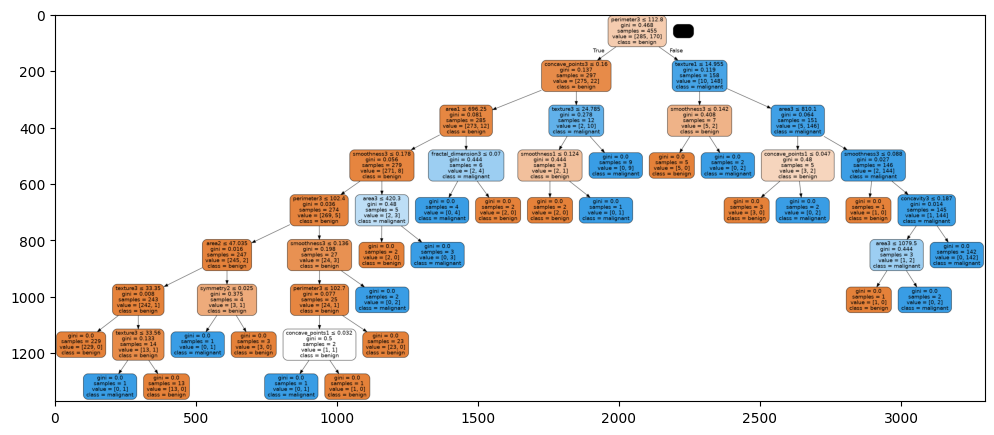

With maximum depth of 2:


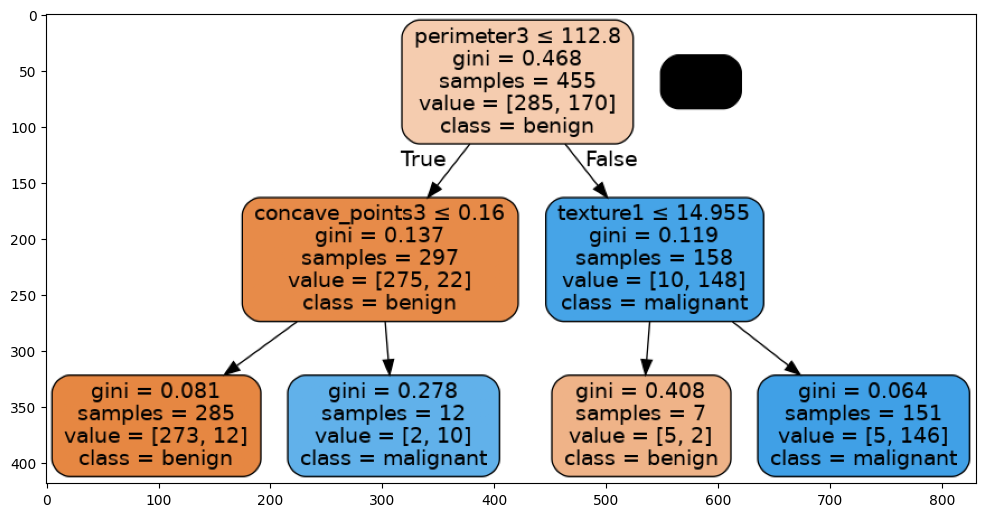

With maximum depth of 3:


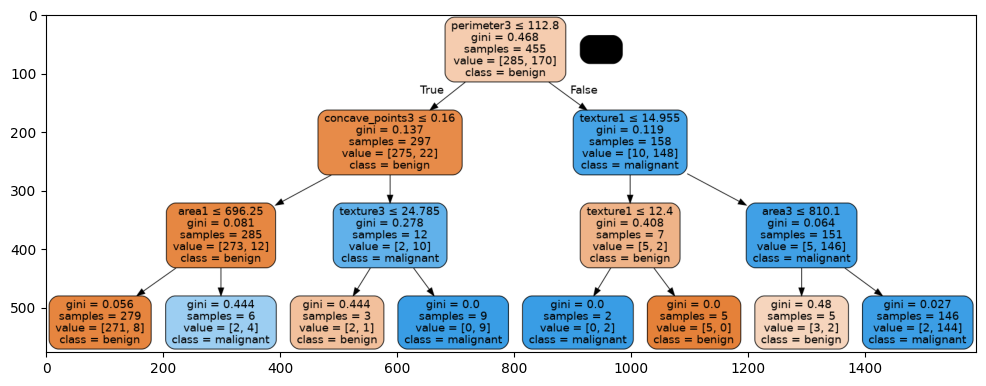

With maximum depth of 4:


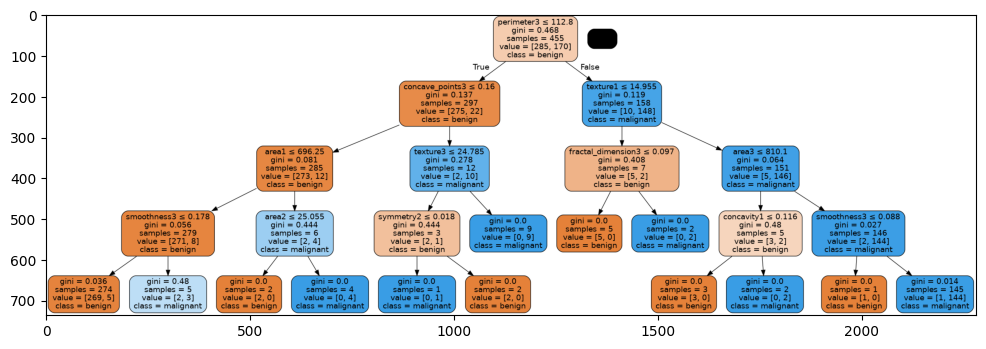

With maximum depth of 5:


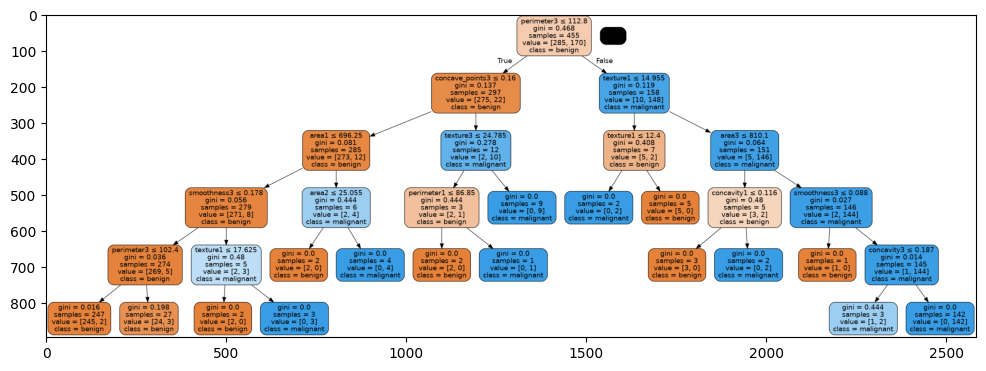

With maximum depth of 6:


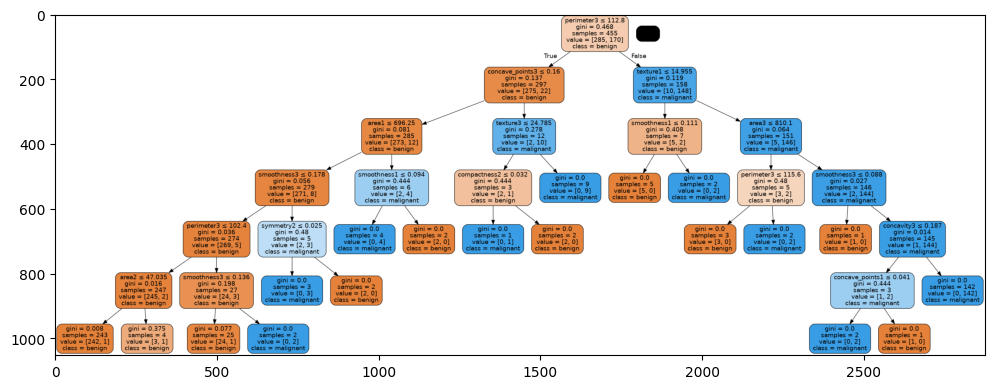

With maximum depth of 7:


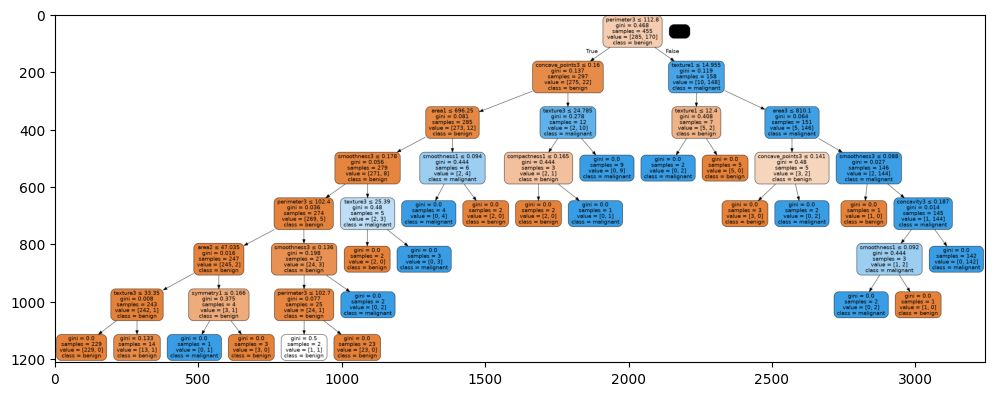

In [16]:
if os.path.exists('images/depth_accuracy') == False:
    os.mkdir('images/depth_accuracy')

accuracies = dict()

print(f'Visualization of Decision Tree Classifier on dataset of 80/20')
for max_depth, model in models_max_depth.items():
    print(f'With maximum depth of {max_depth}:')
    export_model_image(model, f'images/depth_accuracy/max_depth_{max_depth}')
    accuracies[max_depth] = accuracy_score(y_test, model.predict(X_test))

Table of correlation between values of `max_depth` and `accuracy_score` of the decision tree.

In [17]:
accuracy_table = pd.DataFrame({'max_depth': list(accuracies.keys()), 'Accuracy': list(accuracies.values())})
accuracy_table = accuracy_table.transpose()
accuracy_table.columns = accuracy_table.iloc[0]
accuracy_table = accuracy_table[1:]
accuracy_table.columns = ['None', '2', '3', '4', '5', '6', '7']

accuracy_table

,None,2,3,4,5,6,7
Accuracy,0.929825,0.921053,0.903509,0.912281,0.912281,0.921053,0.929825


*For comments, please refer to the report document.*